# C1
# Прогнозирование временных рядов

## курс "Машинное обучение 2", программа OzonMasters, 2022

## Студент: Арешин Станислав Олегович

## Baseline 2

В данном ноутбуке представлено итоговое решение, которое с запасом побило второй бейслайн. Скор решения на паблике 3.17186 при бейслайне 12.46734.

**Идея решения**

*В основном это развитая идея, которая описана в ноутбуке baseline1_best_solution, некоторые моменты вкратце повторю и укажу улучшения*

* В ходе проведения EDA было выявлено, что период цикла рядов 24 значения. В прошлом решении использовалось 24 лага, но в ходе экспериментов выявлено, что чем больше лагов брать, тем лучше становится решение. Минимальная длина ряда 75 значений (см. EDA), поэтому было решено для коротких рядов (длиной меньше 100 значений) использовать 24 лага, а для длинных использовать 48 лагов. Эти параметры подбирались несколькими экспериментами, как с одинаковым значением лага для всех рядов ( например 24 лага, 36 лагов), так и с разными в зависимости от длины. Такая комбинация оказалась наилучшей.
* Аналогично для каждого ряда обучаем свою модель линейной регрессии (в данном случае именно Linear Regression, не Ridge)
* Аналогично для составления лагов в обучающей выборке используется функция  get_lag_features, появившиеся наны просто удаляются.
* Аналогично для предсказаний используется функция get_last_vals, которая выделяет из обучения последние n значений каждого ряда для первого предикта на тесте, и функция make_prediction, которая работает следующим образом: для каждого ряда обучается модель линейной регрессии, первый предикт делается по последним значениям трейна, затем значения сдвигаются на 1, а предкит текущего шага добавляется как первый лаг для следующего шага. В результате таким рекурсивным добавлением делаются предсказания, ошибка не сильно накапливается.
* Было решено отказаться от признаков trend, min(window) и max(window), так как они утягивают некоторые ряды и нарушают их поведение 
* Линейная регрессия при данном подходе дает результаты точнее Ridge регрессии, поэтому используем её.
* К сожалению, такое решение предсказывает еще дольше за счёт большего количества лагов, но это можно попробовать оптимизировать при надобности.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

%matplotlib inline

# Загрузка данных

In [2]:
df_train = pd.read_parquet('train.parquet', engine='pyarrow')
df_train.head()

,item_id,vals_id,epoch,value
0,0,0,2014-01-01 00:00:00,3.237531
1,0,1,2014-01-01 00:18:57,1.835517
2,0,2,2014-01-01 00:37:54,0.751695
3,0,3,2014-01-01 00:56:51,0.077846
4,0,4,2014-01-01 01:15:48,-0.161371


In [3]:
df_test = pd.read_parquet('test.parquet', engine='pyarrow')
df_test.head()

,item_id,vals_id,epoch
0,0,3646,2014-02-17 23:31:42
1,0,3647,2014-02-17 23:50:39
2,0,3648,2014-02-18 00:09:36
3,0,3649,2014-02-18 00:28:33
4,0,3650,2014-02-18 00:47:30


In [4]:
submission_sample = pd.read_csv('submission_sample.csv')
print(len(submission_sample))
submission_sample.head()

780762


,row,value
0,0_3646,0.202660
1,0_3647,0.671267
2,0_3648,0.675564
3,0_3649,0.179560
4,0_3650,0.615844


# Генерация лагов

In [9]:
num_lags1 = 48
num_lags2 = 24

In [10]:
size_groups = df_train.groupby('item_id').size()

lags48_id = list(size_groups[size_groups >= 100].index)
lags24_id = list(size_groups[size_groups < 100].index)

In [11]:
df_train_lag48 = df_train[df_train['item_id'].isin(lags48_id)]
df_train_lag24 = df_train[df_train['item_id'].isin(lags24_id)]

In [12]:
def get_lag_features(df, num_lags):
    for i in range(1, num_lags + 1):
        df[f'lag{i}'] =  df.groupby('item_id')['value'].shift(i)
    return df

In [13]:
df_train_lag48 = get_lag_features(df_train_lag48, num_lags1)
df_train_lag48.dropna(inplace=True)
df_train_lag48.head()

,item_id,vals_id,epoch,value,lag1,lag2,lag3,lag4,lag5,lag6,...,lag39,lag40,lag41,lag42,lag43,lag44,lag45,lag46,lag47,lag48
48,0,48,2014-01-01 15:09:36,3.215571,4.784798,6.346680,7.738768,8.843937,9.600770,9.996159,...,3.310611,2.235956,1.279133,0.509548,0.003750,-0.161371,0.077846,0.751695,1.835517,3.237531
49,0,49,2014-01-01 15:28:33,1.815597,3.215571,4.784798,6.346680,7.738768,8.843937,9.600770,...,4.442755,3.310611,2.235956,1.279133,0.509548,0.003750,-0.161371,0.077846,0.751695,1.835517
50,0,50,2014-01-01 15:47:30,0.734493,1.815597,3.215571,4.784798,6.346680,7.738768,8.843937,...,5.580232,4.442755,3.310611,2.235956,1.279133,0.509548,0.003750,-0.161371,0.077846,0.751695
51,0,51,2014-01-01 16:06:27,0.063436,0.734493,1.815597,3.215571,4.784798,6.346680,7.738768,...,6.676908,5.580232,4.442755,3.310611,2.235956,1.279133,0.509548,0.003750,-0.161371,0.077846
52,0,52,2014-01-01 16:25:24,-0.173426,0.063436,0.734493,1.815597,3.215571,4.784798,6.346680,...,7.690125,6.676908,5.580232,4.442755,3.310611,2.235956,1.279133,0.509548,0.003750,-0.161371


In [14]:
df_train_lag24 = get_lag_features(df_train_lag24, num_lags2)
df_train_lag24.dropna(inplace=True)
df_train_lag24.head()

,item_id,vals_id,epoch,value,lag1,lag2,lag3,lag4,lag5,lag6,...,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24
92735,111,24,2014-01-13 02:25:12,0.469141,-2.748298,-3.125415,-3.108504,-3.026570,-2.932130,-2.836683,...,-1.930631,-1.794776,-1.640321,-1.459918,-1.241918,-0.966380,-0.595743,-0.051697,0.801392,0.092097
92736,111,25,2014-01-13 14:31:15,1.258428,0.469141,-2.748298,-3.125415,-3.108504,-3.026570,-2.932130,...,-2.052832,-1.930631,-1.794776,-1.640321,-1.459918,-1.241918,-0.966380,-0.595743,-0.051697,0.801392
92737,111,26,2014-01-14 02:37:18,0.417683,1.258428,0.469141,-2.748298,-3.125415,-3.108504,-3.026570,...,-2.164899,-2.052832,-1.930631,-1.794776,-1.640321,-1.459918,-1.241918,-0.966380,-0.595743,-0.051697
92738,111,27,2014-01-14 14:43:21,-0.107437,0.417683,1.258428,0.469141,-2.748298,-3.125415,-3.108504,...,-2.269471,-2.164899,-2.052832,-1.930631,-1.794776,-1.640321,-1.459918,-1.241918,-0.966380,-0.595743
92739,111,28,2014-01-15 02:49:24,-0.457536,-0.107437,0.417683,1.258428,0.469141,-2.748298,-3.125415,...,-2.368630,-2.269471,-2.164899,-2.052832,-1.930631,-1.794776,-1.640321,-1.459918,-1.241918,-0.966380


In [15]:
def get_last_vals(df_train, size):
    result = pd.DataFrame([])
    for item_id in tqdm(pd.unique(df_train['item_id'])):
        max_val = df_train[df_train['item_id'] == item_id]['vals_id'].max()
        last_values = df_train[(df_train['item_id'] == item_id) & 
                df_train['vals_id'].isin(list(range(max_val - size + 1, max_val + 1)))]
        result = pd.concat([result, last_values])
    return result

In [16]:
last_values48 = get_last_vals(df_train_lag48, num_lags1)
last_values48.head()

100%|██████████████████████████████████████████████████████████████████████████████| 3552/3552 [03:35<00:00, 16.48it/s]


,item_id,vals_id,epoch,value,lag1,lag2,lag3,lag4,lag5,lag6,...,lag39,lag40,lag41,lag42,lag43,lag44,lag45,lag46,lag47,lag48
3598,0,3598,2014-02-17 08:22:06,0.791408,2.254542,3.477840,4.367388,4.886092,5.042045,4.871476,...,-3.171429,-3.945920,-4.497655,-4.759603,-4.669377,-4.183282,-3.295427,-2.055946,-0.577547,0.979383
3599,0,3599,2014-02-17 08:41:03,-0.765140,0.791408,2.254542,3.477840,4.367388,4.886092,5.042045,...,-2.237936,-3.171429,-3.945920,-4.497655,-4.759603,-4.669377,-4.183282,-3.295427,-2.055946,-0.577547
3600,0,3600,2014-02-17 09:00:00,-2.242032,-0.765140,0.791408,2.254542,3.477840,4.367388,4.886092,...,-1.202828,-2.237936,-3.171429,-3.945920,-4.497655,-4.759603,-4.669377,-4.183282,-3.295427,-2.055946
3601,0,3601,2014-02-17 09:18:57,-3.479224,-2.242032,-0.765140,0.791408,2.254542,3.477840,4.367388,...,-0.117034,-1.202828,-2.237936,-3.171429,-3.945920,-4.497655,-4.759603,-4.669377,-4.183282,-3.295427
3602,0,3602,2014-02-17 09:37:54,-4.364551,-3.479224,-2.242032,-0.765140,0.791408,2.254542,3.477840,...,0.973473,-0.117034,-1.202828,-2.237936,-3.171429,-3.945920,-4.497655,-4.759603,-4.669377,-4.183282


In [17]:
last_values24 = get_last_vals(df_train_lag24, num_lags2)
last_values24.head()

100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 691.67it/s]


,item_id,vals_id,epoch,value,lag1,lag2,lag3,lag4,lag5,lag6,...,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24
92782,111,71,2014-02-05 19:09:33,-0.499145,-0.752979,-0.750594,-0.701743,-0.644483,-0.587623,-0.532930,...,0.043623,0.158519,0.301852,0.487305,0.738886,1.103150,1.679023,2.553924,0.209385,-1.892672
92783,111,72,2014-02-06 07:15:36,1.736835,-0.499145,-0.752979,-0.750594,-0.701743,-0.644483,-0.587623,...,-0.051300,0.043623,0.158519,0.301852,0.487305,0.738886,1.103150,1.679023,2.553924,0.209385
92784,111,73,2014-02-06 19:21:39,3.913849,1.736835,-0.499145,-0.752979,-0.750594,-0.701743,-0.644483,...,-0.131853,-0.051300,0.043623,0.158519,0.301852,0.487305,0.738886,1.103150,1.679023,2.553924
92785,111,74,2014-02-07 07:27:42,3.036367,3.913849,1.736835,-0.499145,-0.752979,-0.750594,-0.701743,...,-0.201969,-0.131853,-0.051300,0.043623,0.158519,0.301852,0.487305,0.738886,1.103150,1.679023
92786,111,75,2014-02-07 19:33:45,2.466413,3.036367,3.913849,1.736835,-0.499145,-0.752979,-0.750594,...,-0.264571,-0.201969,-0.131853,-0.051300,0.043623,0.158519,0.301852,0.487305,0.738886,1.103150


# Предсказания занчений рядов

In [18]:
columns1 = ['vals_id', 'lag1','lag2','lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9','lag10',
           'lag11' ,'lag12', 'lag13', 'lag14', 'lag15', 'lag16','lag17', 'lag18', 'lag19', 'lag20',
           'lag21', 'lag22', 'lag23','lag24', 'lag25','lag26','lag27', 'lag28', 'lag29', 'lag30', 'lag31',
           'lag32', 'lag33','lag34', 'lag35' ,'lag36','lag37','lag38','lag39','lag40','lag41','lag42',
            'lag43','lag44','lag45','lag46','lag47','lag48']

columns2 = ['vals_id', 'lag1','lag2','lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9','lag10',
           'lag11' ,'lag12', 'lag13', 'lag14', 'lag15', 'lag16','lag17', 'lag18', 'lag19', 'lag20',
           'lag21', 'lag22', 'lag23','lag24']

In [19]:
from sklearn.linear_model import LinearRegression

def make_prediction(df_train, df_train_lag1, df_train_lag2, df, last_vals1, last_vals2 , cols1, cols2, num_lags1, num_lags2):
    df_test = df.copy()
    
    features_creted = []
    res = []
    for _, row in tqdm(df_test.iterrows()): 
        if row['item_id'] in features_creted:
            
            row['lag1'] = prev_row['value']
            for i in range(2, num_lags + 1):
                row[f'lag{i}'] = prev_row[f'lag{i - 1}']

            value = model.predict(np.array([np.array(row[cols])]))
            
            row['value'] = value[0]
            res_row = row[['item_id', 'vals_id', 'value']].to_list()
            res.append(res_row)

            prev_row = row.copy()
        else:
                
            df_len = len(df_train[df_train['item_id'] == row['item_id']])
            
            if df_len >= 100:
                df_item = df_train_lag1[df_train_lag1['item_id'] == row['item_id']]
                features = last_vals1[last_vals1['item_id'] == row['item_id']]
                num_lags = num_lags1
                cols = cols1
            else:
                df_item = df_train_lag2[df_train_lag2['item_id'] == row['item_id']]
                features = last_vals2[last_vals2['item_id'] == row['item_id']]
                num_lags = num_lags2
                cols = cols2   
            
            X_train = np.array(df_item[cols])
            y_train = np.array(df_item['value'])
            model = LinearRegression()
            model.fit(X_train, y_train)
            
            features_creted.append(row['item_id'])
            
            for i in range(1, num_lags + 1):
                row[f'lag{i}'] = features.iloc[num_lags - i]['value']
        
            
            value = model.predict(np.array([np.array(row[cols])]))
            row['value'] = value[0]
            res_row = row[['item_id', 'vals_id', 'value']].to_list()
            res.append(res_row)
            prev_row = row.copy()
            
    res = pd.DataFrame(res, columns = ['item_id', 'vals_id','value'])
    return res

In [20]:
res = make_prediction(df_train, df_train_lag48, df_train_lag24,
                      df_test, last_values48, last_values24,
                      columns1, columns2, num_lags1, num_lags2)

780762it [4:21:42, 49.72it/s]


In [9]:
res

,item_id,vals_id,value
0,0,3646,0.597015
1,0,3647,-0.959157
2,0,3648,-2.434517
3,0,3649,-3.669377
4,0,3650,-4.552128
...,...,...,...
780757,3599,1500,1.567193
780758,3599,1501,2.119188
780759,3599,1502,2.737780
780760,3599,1503,3.421412


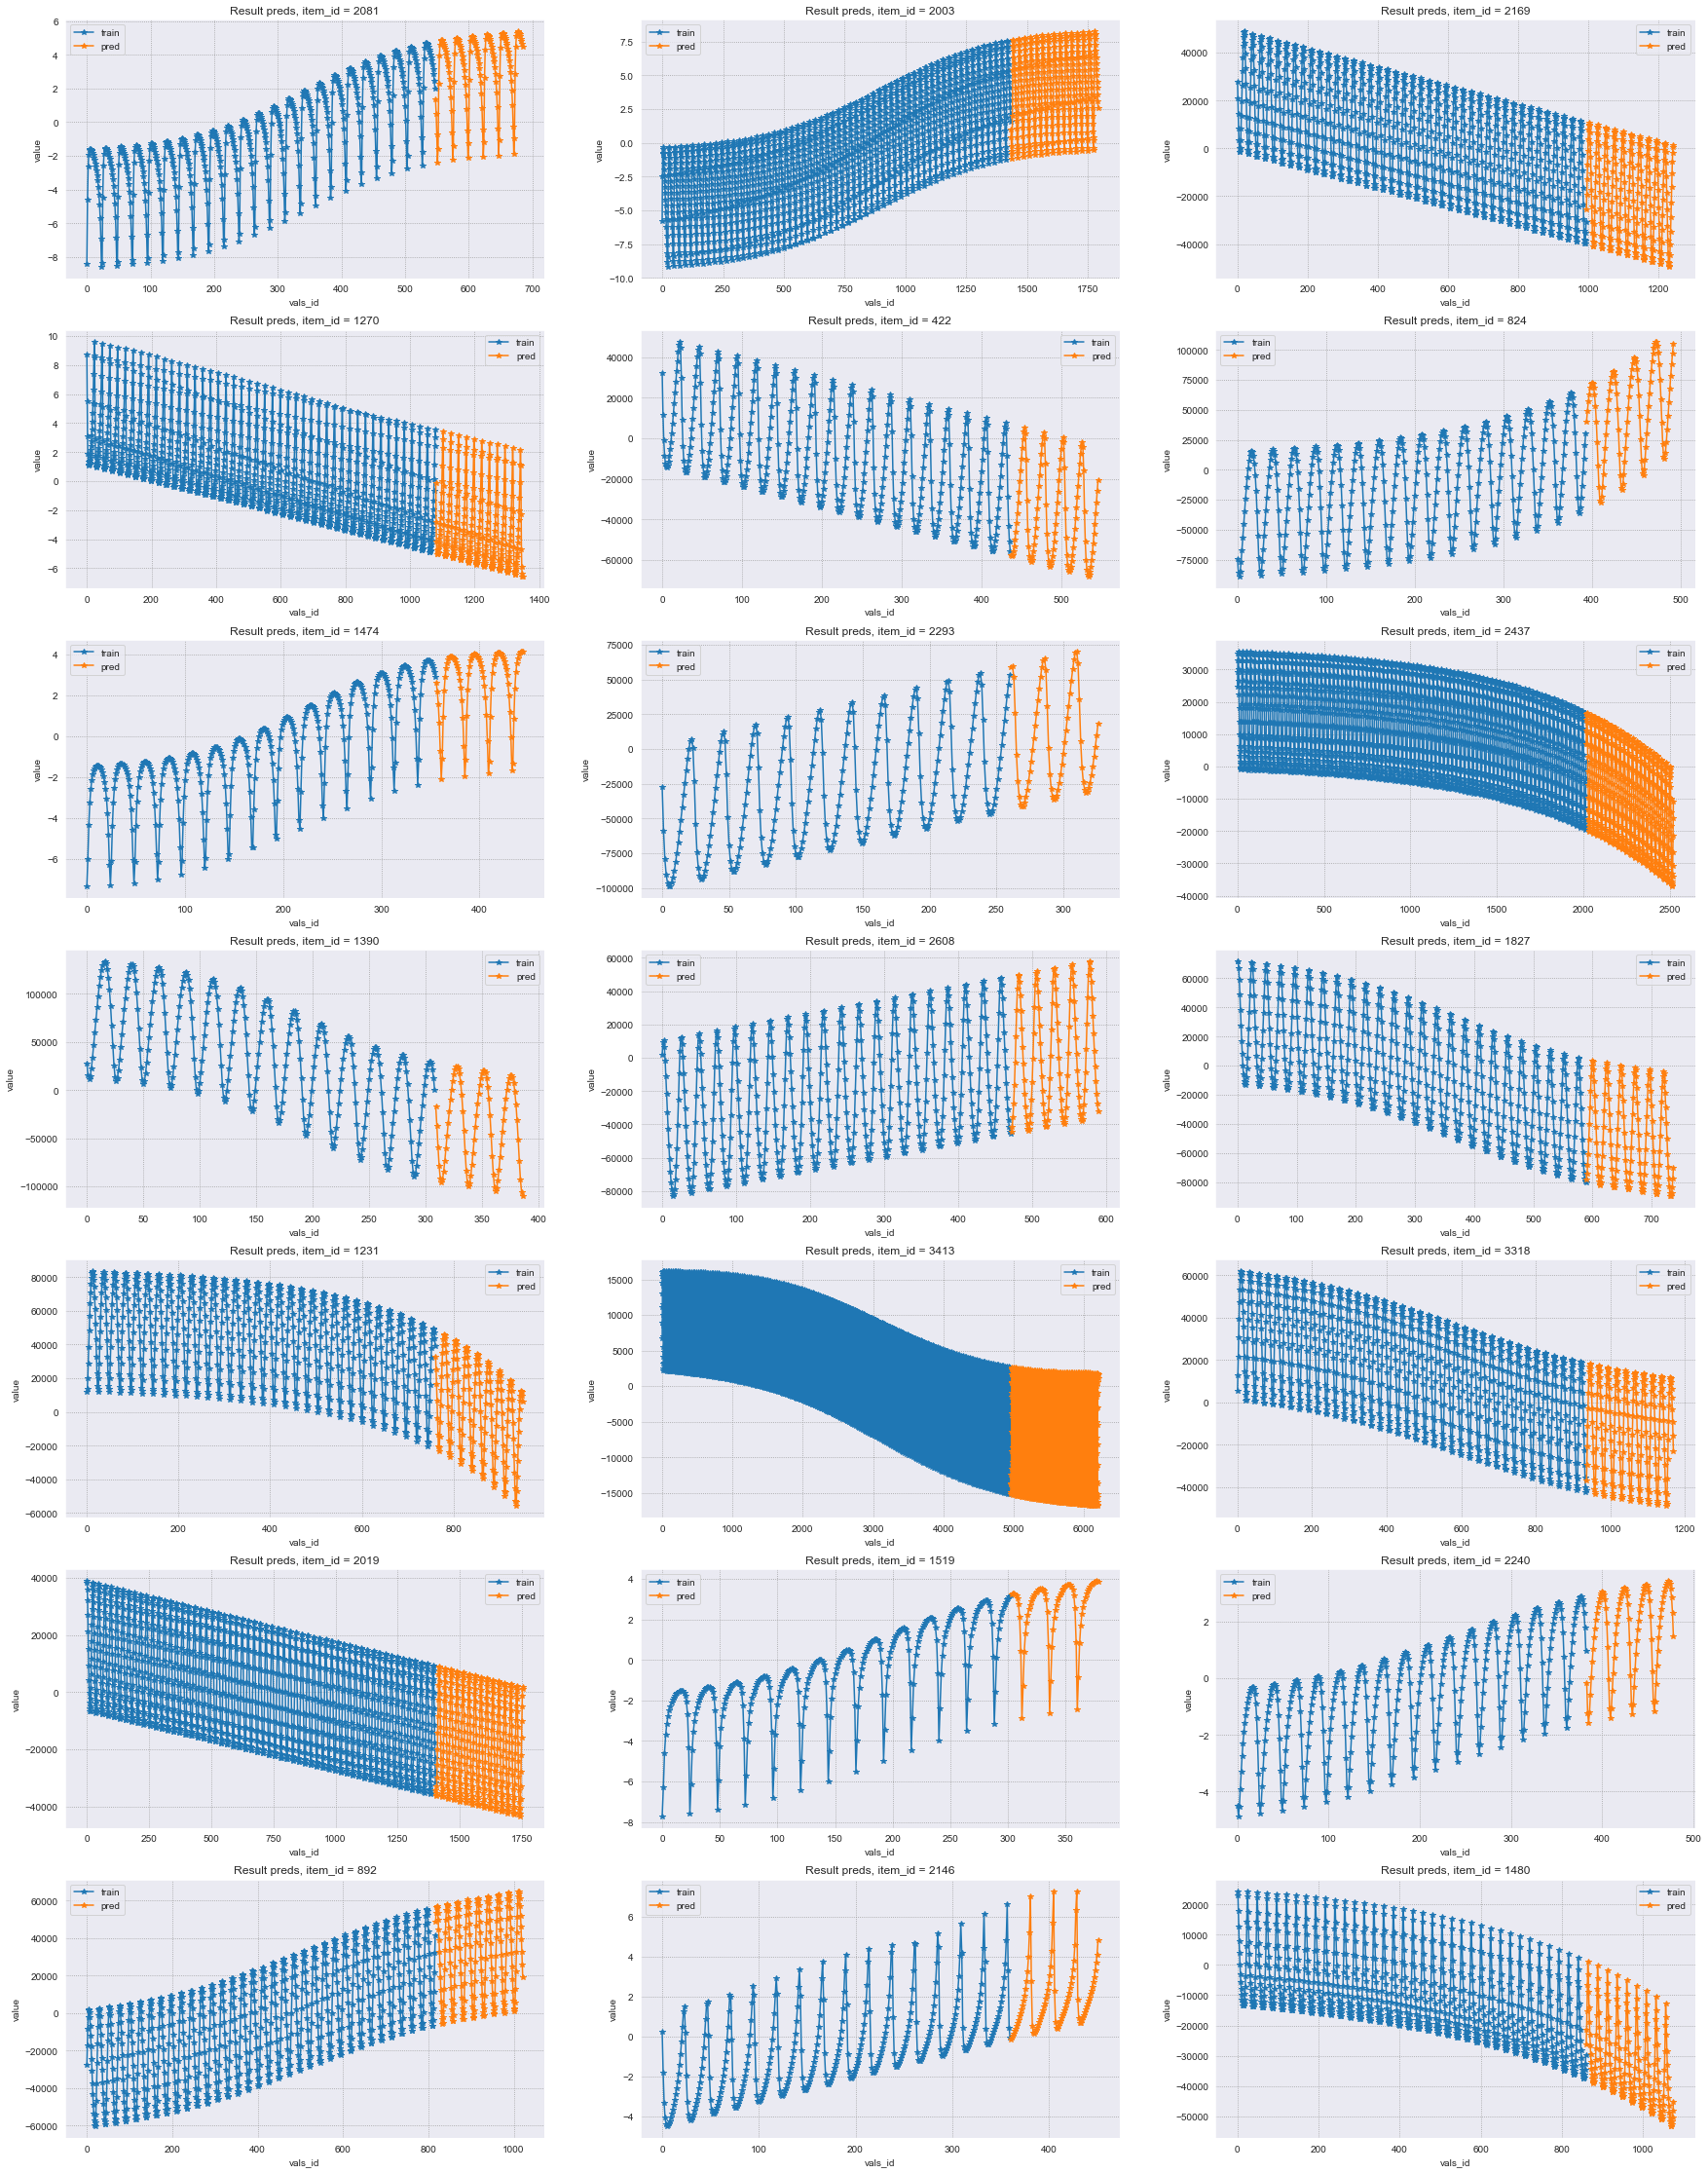

In [15]:
# визуализируем 21 случайный результат
random_ind = np.random.choice(list(set(df_train['item_id'].values)), 21, replace=False)
plt.figure(figsize = (30, 40))
for i, j in enumerate(random_ind):
    ax = plt.subplot(round(len(random_ind) / 3), 3, i + 1)
    ax.set_title(f'Result preds, item_id = {j}')
    ax.plot(np.array(df_train[df_train['item_id'] == j]['vals_id']),
         np.array(df_train[df_train['item_id'] == j]['value']), label='train', marker = '*')
    ax.plot(np.array(res[res['item_id'] == j]['vals_id']),
            np.array(res[res['item_id'] == j]['value']), label = 'pred', marker = '*')
    ax.legend()
    ax.set_xlabel('vals_id')
    ax.set_ylabel('value')
plt.show()

In [23]:
res.to_csv('res_miltilinreg48_24.csv', index=False)

In [24]:
res = res.astype({'item_id': int, 'vals_id': int})
res = res.astype({'item_id': str, 'vals_id': str})

res_submit = pd.DataFrame()

res_submit['row'] = res['item_id'] + '_'+ res['vals_id']
res_submit['value'] = res['value']

res_submit

,row,value
0,0_3646,0.597015
1,0_3647,-0.959157
2,0_3648,-2.434517
3,0_3649,-3.669377
4,0_3650,-4.552128
...,...,...
780757,3599_1500,1.567193
780758,3599_1501,2.119188
780759,3599_1502,2.737780
780760,3599_1503,3.421412


In [25]:
res_submit.to_csv('submit_miltilinreg_lag48_24.csv', index=False)

# Итог

При нескольких запусках видно, что не все временные ряды прогнозируются идеально, но на плохой прогноз надо постараться наткнуться. Результат гораздо лучше, чем был при самом первом успешном решении (ноутбук baseline1_best_solution), можно попробовать отдельно обрабатывать ряды с большой ошибкой SMAPE, больше перспектив данного подхода я не вижу.